In [165]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# 用 pipeline 串接 StandardScaler, PCA, LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.model_selection import cross_val_score

# Plot learning curve
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Validations
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

# 調整svm的kernel 參數 以及C 參數
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support

In [152]:
df = pd.read_csv('D:\Courses\資策會_大數據班_BB105\專題\IOT\IOT-Data\joined_table.csv', engine='python')
print('untired count: ' + str(len(df[df['label'] == 0])))
print('tired count: ' + str(len(df[df['label'] == 1])))

x = df.loc[:, ['Z_acc','BPM']]
y = df.loc[:, 'label']
print('columns: ' + str(x.columns))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

untired count: 7375
tired count: 5917
columns: Index(['Z_acc', 'BPM'], dtype='object')


## Logistic Regression

### Hyperparameters #1

In [137]:
sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

lr = LogisticRegression(C=1000.0, random_state=1)
lr.fit(x_train_std, y_train)

y_pred = lr.predict(x_test_std)
print('資料什麼都沒清理 Logistic Regression Accuracy: %.3f' % accuracy_score(y_test, y_pred))

資料什麼都沒清理 Logistic Regression Accuracy: 0.556


### Hyperparameters #2

In [147]:
# pipeline 的輸入是 tuple ('識別字串',轉換器或是估計器(參數))
# 管線中最後一項會是估計器
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])

pipe_lr.fit(x_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(x_test, y_test))

# y_pred = pipe_lr.predict(x_test)
# Counter(y_pred)

# 直接用cross_val_score評估模型
scores = cross_val_score(estimator=pipe_lr,
                         X=x_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
# n_jobs : The number of CPUs to use to do the computation. -1 means ‘all CPUs’.
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Test Accuracy: 0.556
CV accuracy scores: [ 0.55901288  0.54564984  0.55961332  0.56021505  0.55913978  0.5516129
  0.55053763  0.5516129   0.55483871  0.54731183]
CV accuracy: 0.554 +/- 0.005


### Learning Curve

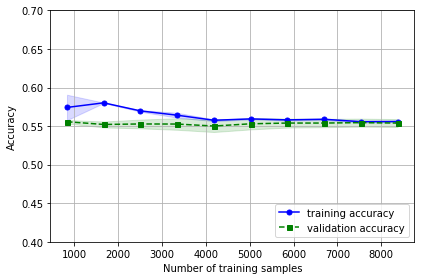

In [163]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))])
# penalty='l2' : 正規化
train_sizes, train_scores, validation_scores =\
                learning_curve(estimator=pipe_lr,
                               X=x_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)
# train_sizes=np.linspace(0.1, 1.0, 10) 
# array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, validation_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 validation_mean + validation_std,
                 validation_mean - validation_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.4, 0.7])
plt.tight_layout()

plt.show()

### Validation Curve

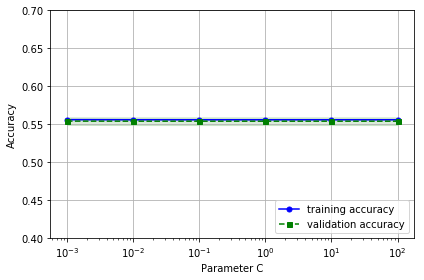

In [159]:
#驗證想要評估的參數C對正確率的影響

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, validation_scores = validation_curve(
                estimator=pipe_lr, 
                X=x_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, validation_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 validation_mean + validation_std,
                 validation_mean - validation_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.4, 0.7])
plt.tight_layout()
plt.show()

### Grid Search using SVM

In [166]:
pipe_svc = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=1))])
# 參數的範圍
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
# 一次調好幾個參數   字典類型的list 傳入
param_grid = [{'clf__C': param_range, 
               'clf__kernel': ['linear']},
                 {'clf__C': param_range, 
                  'clf__gamma': param_range, 
                  'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(x_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.613069647463
{'clf__C': 1.0, 'clf__gamma': 10.0, 'clf__kernel': 'rbf'}


### Pick best hyperparameters to train

In [172]:
%timeit clf = gs.best_estimator_
%timeit clf.fit(x_train, y_train)
print('Test accuracy: %.3f' % clf.score(x_test, y_test))


55.3 ns ± 0.696 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
3.91 s ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Test accuracy: 0.602


### Confusion Matrix

In [ ]:
y_pred = pipe_lr.predict(x_test)

precision_recall_fscore_support(y_test, y_pred)

## SVM

In [102]:
svm = SVC(kernel='rbf', random_state=0, gamma=0.5, C=1.0)
# svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(x_train_std, y_train)
y_pred = svm.predict(x_test_std)
print('資料什麼都沒清理 SVM Accuracy: %.2f' % accuracy_score(y_test, y_pred))

資料什麼都沒清理 SVM Accuracy: 0.60


## RNN

In [57]:
mat1 = np.matrix([[1,0,0],[0,1,0]])
mat2 =  np.matrix([[0],[1]])
np.multiply(mat1, mat2)

matrix([[1, 0, 0],
        [0, 1, 0]])

In [67]:
mat1 = np.array([[1,0,0],[0,1,0]]) # 2x3
mat2 =  np.array([0,1]) # 1x2
mat2.dot(mat1) # must be 1x2 * 2x3 

array([0, 1, 0])

In [65]:
np.arange(1,5)

numpy.ndarray